# Naive Bayes Sentiment Classification Program

In [1]:
# unit test classifier 
from util import NB_DataHandler
import sys
import time
import matplotlib.pyplot as plt

amazon = "amazon_cells_labelled.txt"
imdb = "imdb_labelled.txt"
yelp = "yelp_labelled.txt"
test_file = input("Input Unit test file name: ")

v2 = NB_DataHandler(amazon, imdb, yelp, quiet=False)
res = v2.test()
print("Initial Train Accuracy:\t{}%".format(str(round(res,3))))

Input Unit test file name: imdb_labelled.txt
amazon_cells_labelled.txt Finished on line 1000 with 11956 words

imdb_labelled.txt Finished on line 1000 with 16645 words

yelp_labelled.txt Finished on line 1000 with 12677 words

=====Summary=====
Unique words:	 -> 3456
Total words:	 -> 32698
Total data:	 -> 3000
Train data:	 -> 2400
Test data:	 -> 600

35 words removed from vocabulary

Log probabilities calculated

Initial Train Accuracy:	83.167%


Selecting best model for unit testing out of 100 runs...

run 10: 20.907s
run 20: 40.028s
run 30: 62.701s
run 40: 83.336s
run 50: 98.764s
run 60: 113.792s
run 70: 129.075s
run 80: 144.689s
run 90: 161.26s
run 100: 190.729s
Max accuracy on run 55:	85.833% 
Average accuracy: 82.757% 
time: 193.508s
Do you wish to display Accuracy plot?
[Y/N]: y


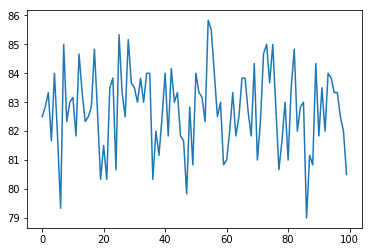

In [2]:
# test accuracy over several runs

runs = 100
run = None
max_res = 0
model = None
vals = []
print("Selecting best model for unit testing out of {} runs...\n".format(runs))
start = time.time()
for i in range(1, runs + 1):
    if i % 10 == 0:
        t = round(time.time() - start, 3)
        print("run {}: {}s".format(i, t))
    v2 = NB_DataHandler(amazon, imdb, yelp)
    res = v2.test()
    if res >= max_res:
        max_res = res
        model = v2
        run = i
    vals.append(res)

avg = sum(vals) / len(vals)
finish = time.time() - start
print("Max accuracy on run {}:\t{}% \nAverage accuracy: {}% \ntime: {}s"
      .format(run, round(max(vals), 3), round(avg, 3), round(finish, 3)))

r = input("Do you wish to display Accuracy plot?\n[Y/N]: ")
if r.lower() == "y":
    plt.plot(vals)
    plt.show()

In [3]:
print("beginning unit test on file: {}\n====================================================\n.......\n".format(
    test_file))

test_res = model.unit_test(test_file)

print("Unit test Accuracy:\t{}%\n".format(round(test_res, 3)))

print("Do you wish to see a detailed report?\nThis will show how the model behaved on each sentences")
i = input("[Y/N]: ")

if i.lower() == "y":
    model.unit_test(test_file, True)

print("End of program")


beginning unit test on file: imdb_labelled.txt
.......

'results_file.txt' created.

Unit test Accuracy:	92.3%

Do you wish to see a detailed report?
This will show how the model behaved on each sentences
[Y/N]: y
'detailed_results_file.txt' created.

End of program
